In [ ]:
#Set up and Read the data
import pandas as pd
import sqlite3


In [ ]:
# read csv file
df_Fact = pd.read_csv('/content/data.csv')


In [ ]:
df_Fact

,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/09/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/09/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/09/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/09/2011 12:50,4.15,12680.0,France


In [ ]:
# connect to database
conn = sqlite3.connect("RFMdb")
cur = conn.cursor()


In [ ]:
# load CRM data into the RFMdb database
df_Fact.to_sql("data", conn)


541909

In [ ]:
df_Fact1 = pd.read_sql('SELECT * FROM data', conn)
df_Fact1


,index,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/09/2011 12:50,0.85,12680.0,France
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/09/2011 12:50,2.10,12680.0,France
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/09/2011 12:50,4.15,12680.0,France
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/09/2011 12:50,4.15,12680.0,France


In [ ]:
# clean data and group transactions by Customerid
cleandata= pd.read_sql(''' SELECT customerid,
                   MAX(receiptdate) AS last_order_date,
                   COUNT(*) AS count_order,
                   SUM(unitprice*quantity) AS totalprice
            FROM data
            WHERE receiptno NOT LIKE '%C%'
            AND customerid IS NOT NULL
            AND unitprice != 0
            GROUP BY customerid ''', conn)

# Write clean CRM data into the database
cleandata.to_sql("cleandata", conn)



4338

In [ ]:
df_Fact2 = pd.read_sql('SELECT * FROM cleandata', conn)
df_Fact2


,index,CustomerID,last_order_date,count_order,totalprice
0,0,12346.0,1/18/2011 10:01,1,77183.60
1,1,12347.0,12/07/2011 15:52,182,4310.00
2,2,12348.0,9/25/2011 13:13,31,1797.24
3,3,12349.0,11/21/2011 9:51,73,1757.55
4,4,12350.0,02/02/2011 16:01,17,334.40
...,...,...,...,...,...
4333,4333,18280.0,03/07/2011 09:52,10,180.60
4334,4334,18281.0,06/12/2011 10:53,7,80.82
4335,4335,18282.0,12/02/2011 11:43,12,178.05
4336,4336,18283.0,7/14/2011 13:20,756,2094.88


In [ ]:
df_Fact2.dtypes
df_Fact2['last_order_date'] = pd.to_datetime(df_Fact2['last_order_date'])
df_Fact2.dtypes


index                       int64
CustomerID                float64
last_order_date    datetime64[ns]
count_order                 int64
totalprice                float64
dtype: object

In [ ]:
# Create date variable that records recency
import numpy as np
import datetime
df_Fact2["last_order_date"] = df_Fact2["last_order_date"].dt.date
# Create snapshot date
snapshot_date = df_Fact2['last_order_date'].max() + datetime.timedelta(days=1)
print(snapshot_date)
# Aggregate data by each customer
customers = df_Fact2.groupby(['CustomerID']).agg({
   'last_order_date': lambda x: (snapshot_date - x.max()).days,
   'count_order':'sum' ,
   'totalprice': 'sum'})

2011-12-10


In [ ]:
# Rename columns
customers.rename(columns = {'last_order_date': 'Recency',
                            'count_order': 'Frequency',
                            'totalprice': 'MonetaryValue'}, inplace=True)

In [ ]:
customers

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


Text(0.5, 1.0, 'Histogram and Recency')

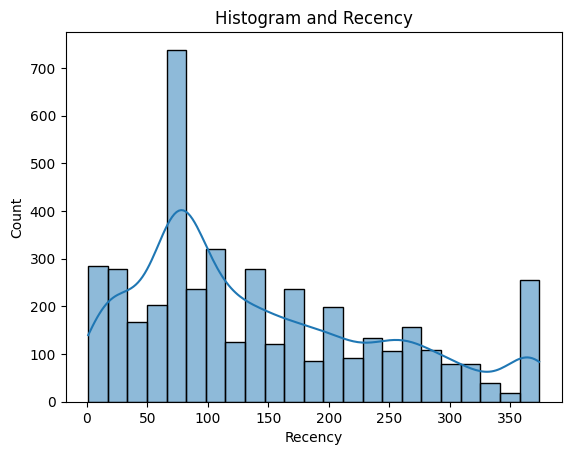

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Recency', kde=True)
ax.set_title('Histogram and Recency')

Text(0.5, 1.0, 'Histogram and Frequency')

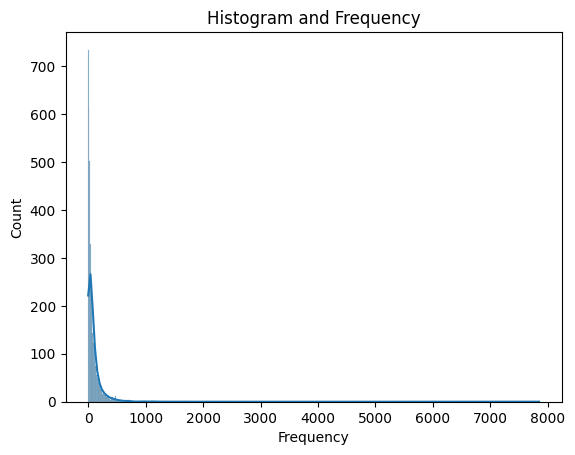

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Frequency', kde=True)
ax.set_title('Histogram and Frequency')

Text(0.5, 1.0, 'Histogram and MonetaryValue')

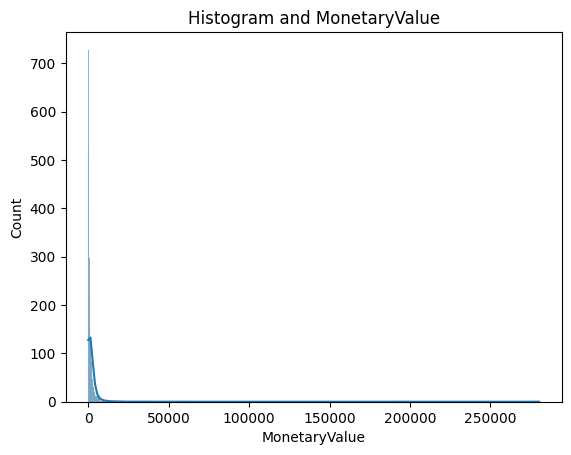

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='MonetaryValue', kde=True)
ax.set_title('Histogram and MonetaryValue')

<ipython-input-16-a7e08f6e9151>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
<ipython-input-16-a7e08f6e9151>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
<ipython-input-16-a7e08f6e9151>:8: UserWarni

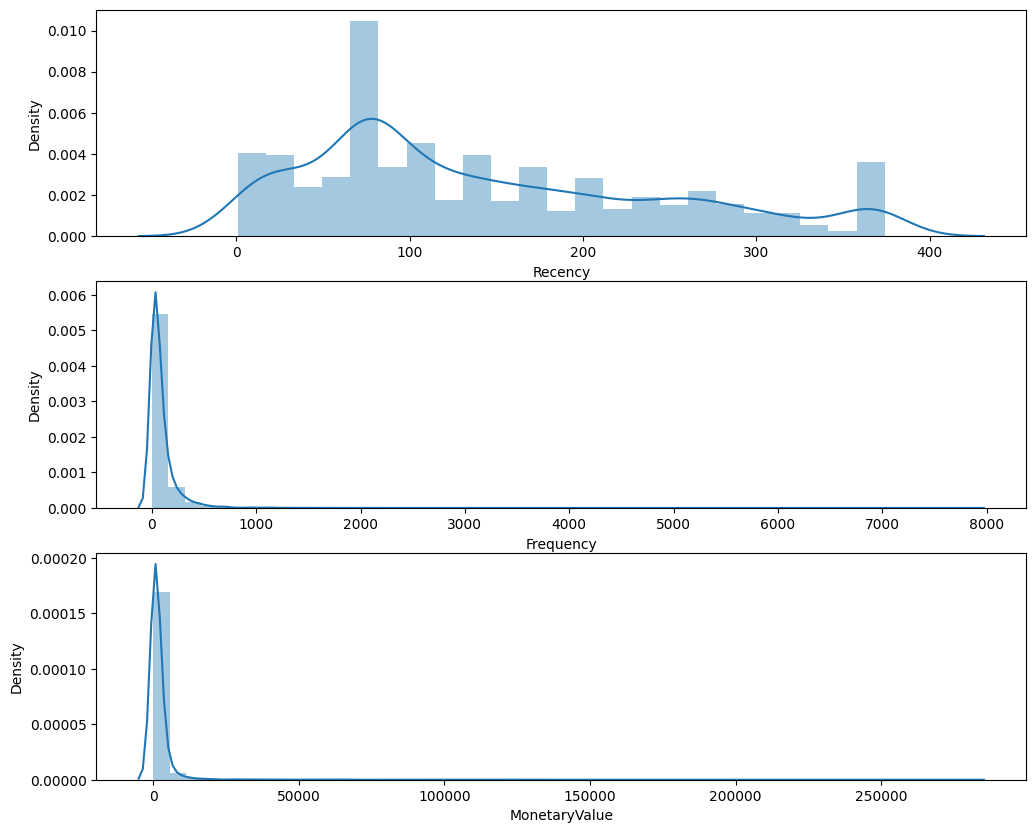

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers['MonetaryValue'])
# Show the plot
plt.show()

In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4333,24.527358,2.444553,4.210941
4334,19.937420,2.046672,3.673259
4335,3.391495,2.650775,4.201744
4336,18.124014,7.898631,5.642809
4337,21.030803,4.748687,5.573391


<ipython-input-18-edbcbb4b2927>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
<ipython-input-18-edbcbb4b2927>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
<ipython-input-18-edbcbb4b2927>:8: U

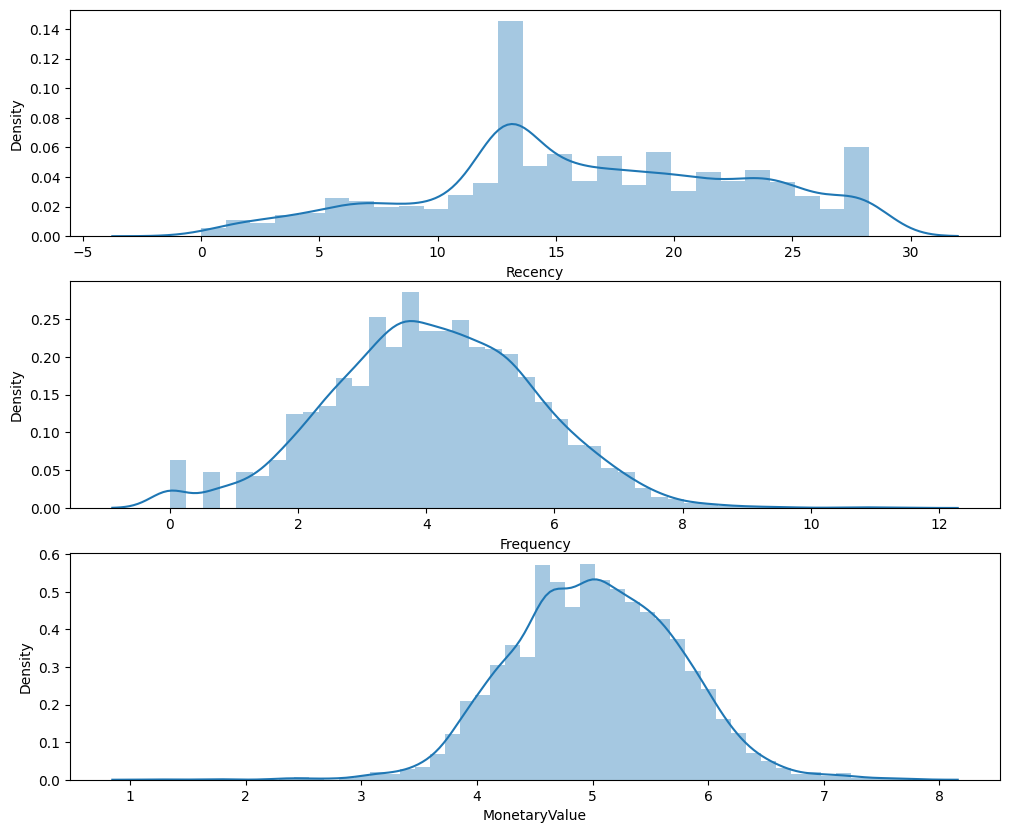

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers_fix['MonetaryValue'])
# Show the plot
plt.show()

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[0. 0. 0.]
[1. 1. 1.]
<built-in method mean of numpy.ndarray object at 0x7fbab19218f0>


In [ ]:
customers_normalized

array([[ 1.51950522, -2.57178095,  3.14411434],
       [-2.23399767,  1.16617768,  1.37604893],
       [-0.51003924, -0.21898305,  0.74977397],
       ...,
       [-1.93719944, -0.91134674, -1.14510853],
       [ 0.27015166,  2.37588685,  0.86284663],
       [ 0.70567157,  0.40277588,  0.76612172]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

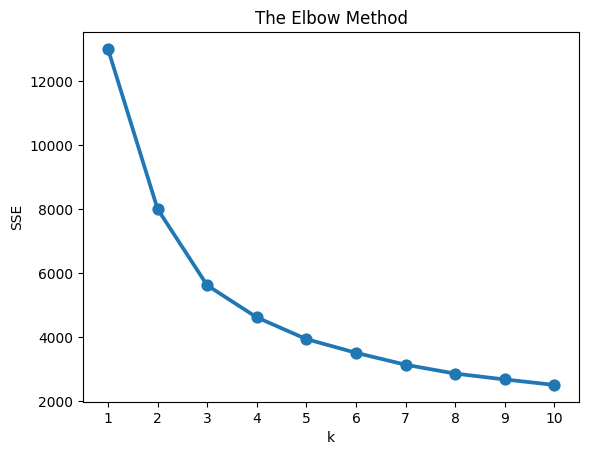

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

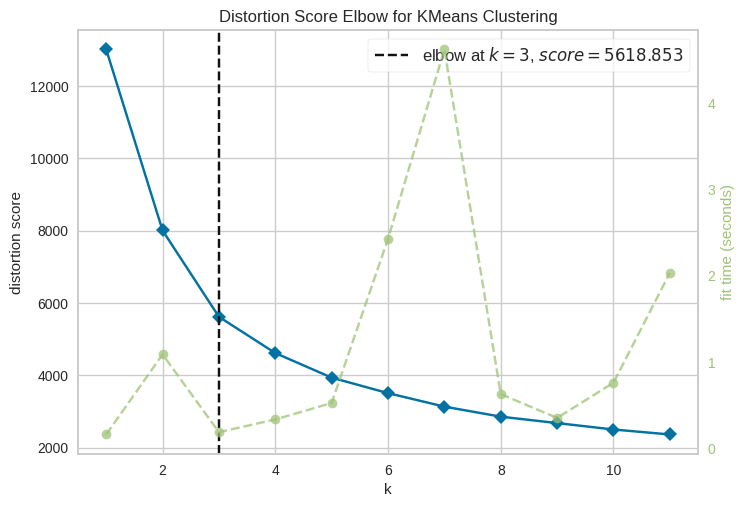

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(customers_normalized)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,MonetaryValue
Cluster,,,
0,788,788,788
1,1071,1071,1071
2,1289,1289,1289
3,1190,1190,1190


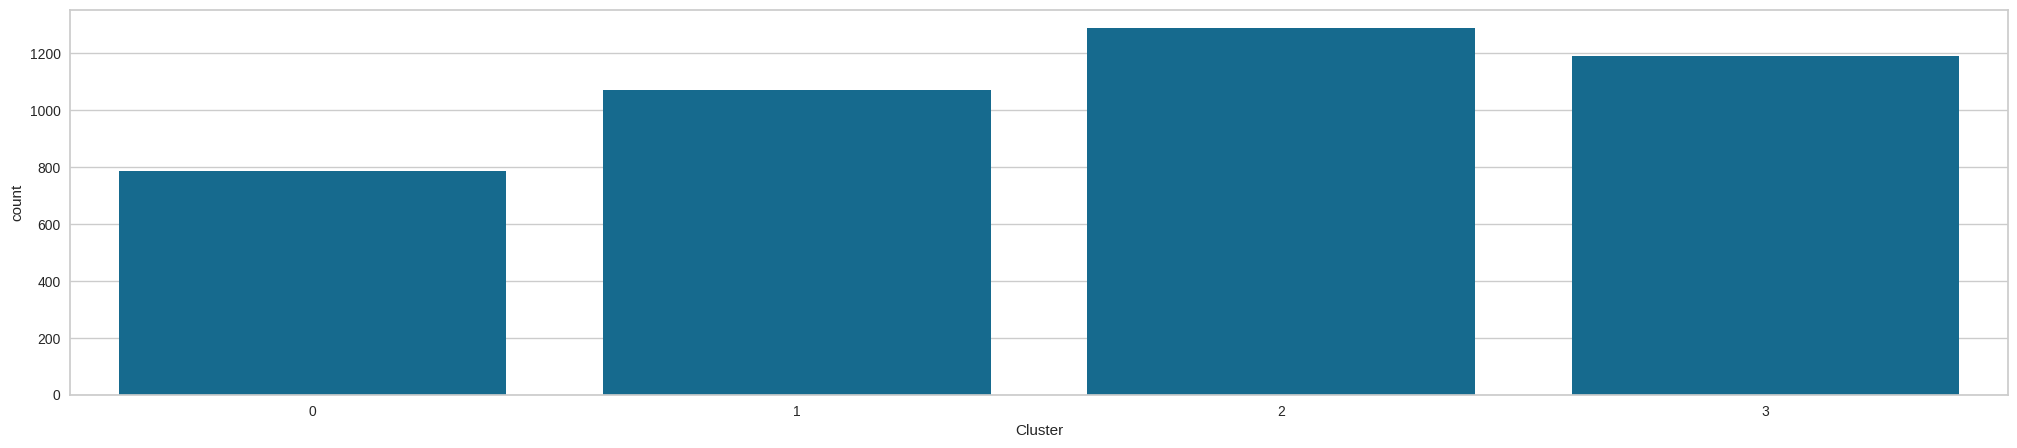

In [ ]:

model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=customers)
customers.groupby(['Cluster']).count()

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        236.85     10.98        222.20   788
1        229.37     56.48       1262.36  1071
2         48.78     34.32        568.03  1289
3        105.88    239.08       5590.04  1190

In [ ]:
customers

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,3,182,4310.00,3
12348.0,76,31,1797.24,2
12349.0,19,73,1757.55,2
12350.0,311,17,334.40,0
...,...,...,...,...
18280.0,278,10,180.60,0
18281.0,181,7,80.82,0
18282.0,8,12,178.05,2


<Axes: xlabel='Attribute', ylabel='Value'>

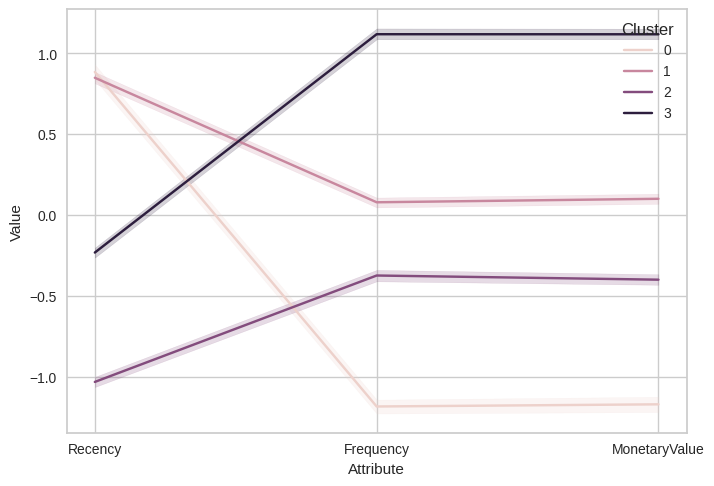

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x = 'Attribute', y= 'Value', hue='Cluster', data=df_nor_melt)